### AWS S3 Bucket data import to Sagemaker Notebook Instance

In [ ]:
import sagemaker
from sagemaker.s3 import S3Downloader

# Set your S3 bucket and data paths
s3_bucket = 
s3_data_prefix =   # Folder containing images
s3_csv_prefix = 

# Define local paths for SageMaker
local_data_path = 
local_csv_path = 

In [ ]:
# Download all images from S3 to local SageMaker storage
S3Downloader.download(f"s3://{s3_bucket}/{s3_data_prefix}", local_data_path)
print(f"✅ Ultrasound images downloaded to: {local_data_path}")

# Download CSV file
S3Downloader.download(f"s3://{s3_bucket}/{s3_csv_prefix}", local_csv_path)
print(f"✅ CSV file downloaded to: {local_csv_path}")

### Data Handling

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Read the CSV file (fix potential spacing issues in column names)
csv_path = "FETAL_PLANES_DB_data.csv"
df = pd.read_csv(csv_path, sep=';')

# Strip column names to avoid hidden spaces
df.columns = df.columns.str.strip()

# Extract image names, labels, and train/test split
image_names = df["Image_name"].values  # Image filenames
labels = df["Plane"].values  # Class labels
train_split = df["Train"].values  # Train/Test indicator (assuming 1 = train, 0 = test)

# Print unique class labels
unique_labels = np.unique(labels)[:]
print(f"Unique labels: {unique_labels}")

Unique labels: ['Fetal abdomen' 'Fetal brain' 'Fetal femur' 'Fetal thorax'
 'Maternal cervix' 'Other']


### Convert Class Labels to Integer Values

In [ ]:
# Create a label mapping dictionary
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Convert labels to integers
encoded_labels = np.array([label_mapping[label] for label in labels])

print("Class Mapping:", label_mapping)

Class Mapping: {'Fetal abdomen': 0, 'Fetal brain': 1, 'Fetal femur': 2, 'Fetal thorax': 3, 'Maternal cervix': 4, 'Other': 5}


### Define Image Transformations for ResNet-50

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

### Create a Custom PyTorch Dataset

In [ ]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_dir, image_names, labels, transform=None, remove_other=False):
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = image_names  # Store image names
        
        # Convert to NumPy arrays for faster filtering
        image_names = np.array(image_names)
        labels = np.array(labels)

        # Remove "Other" class (label 5) if needed
        if remove_other:
            mask = labels != 5  # Select only non-"Other" class samples
            image_names = image_names[mask]
            labels = labels[mask]

        self.image_names = image_names.tolist()
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx] + "_improvement.png"
        img_path = os.path.join(self.image_dir, img_name)

        # Load image, it should load an grayscale image since it's improved only
        image = Image.open(img_path).convert("L")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)


        return image, torch.tensor(label, dtype=torch.long), self.image_names[idx] 

# Example Usage
image_dir = "ultrasound_data"
dataset = UltrasoundDataset(image_dir, image_names, encoded_labels, transform=transform, remove_other=False)

# Test if the first image loads correctly
image, label, _ = dataset[200]

print(f"Final Image Shape: {image.shape}")  # Expected: torch.Size([1, 224, 224]) for improved images



Final Image Shape: torch.Size([1, 224, 224])


### Split Dataset into Training and Test Sets

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Subset

# Extract patient numbers from the first 12 characters of the image names
patient_ids = np.array([name[:12] for name in image_names])

# Convert labels to integers (already done earlier)
encoded_labels = np.array([label_mapping[label] for label in labels])

# ✅ Stratified Group K-Fold Split
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(image_names, encoded_labels, groups=patient_ids))

# ✅ Create training and testing datasets
train_features = UltrasoundDataset(image_dir, image_names[train_idx], encoded_labels[train_idx], transform)
test_features = UltrasoundDataset(image_dir, image_names[test_idx], encoded_labels[test_idx], transform)

# ✅ Data Loaders
batch_size = 32
train_loader = DataLoader(train_features, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_features, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ✅ Confirm Split and Distribution
train_class_counts = np.bincount(encoded_labels[train_idx])
test_class_counts = np.bincount(encoded_labels[test_idx])

print(f"New Train Class Distribution (%): {train_class_counts / len(train_idx) * 100}")
print(f"New Test Class Distribution (%): {test_class_counts / len(test_idx) * 100}")

New Train Class Distribution (%): [ 5.90458678 25.13024824  8.47890489 13.89314537 13.28021248 33.31290224]
New Test Class Distribution (%): [ 5.09383378 24.20528533  8.04289544 13.71122175 12.48563769 36.46112601]


### Verify Everything is Working

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels, image_name = next(iter(train_loader))

# Convert first image to numpy for visualization
image_np = images[0].permute(1, 2, 0).numpy()

# Plot image
plt.imshow(image_np[:, :,], cmap='gray')
plt.title(f"Class: {labels[0].item()}, Name: {image_name[0]}")
plt.show()

### Defining a custom CNN model to extract features from the images
- Although the pretrained models are very powerful, they might not always be the best choice for the given problem.
- Simpler model for the given dataset might perform equally well which would be faster also.

In [ ]:
# Define a custom CNN model to extract features from the images

import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)  # Output: (32, 224, 224)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: (64, 224, 224)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: (128, 224, 224)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Flattened input from CNN layers
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.4)
        

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # (32, 112, 112)
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))  # (64, 56, 56)
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))  # (128, 28, 28)

        x = x.view(x.size(0), -1)  # Flatten layer
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Final classification layer
        
        return F.log_softmax(x, dim=1)  # Softmax for class probabilities
    
    def extract_features(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # (32, 112, 112)
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))  # (64, 56, 56)
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))  # (128, 28, 28)
        
        x = x.view(x.size(0), -1)  # Flatten layer
        x = self.fc1(x)  # Output: (batch_size, 512)
        return x  # Return the 512-dimensional features
    

# Instantiate the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=6).to(device)
print(model)

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


### Training Loop

Using device: cuda


🔥 Epoch 1 | Train Loss: 1.1053, Val Loss: 0.4210, Train Acc: 71.35, Val Acc: 84.83
✅ Saved new best model (Epoch 1, Val Accuracy: 84.83%)


🔥 Epoch 2 | Train Loss: 0.4534, Val Loss: 0.3626, Train Acc: 83.83, Val Acc: 86.52
✅ Saved new best model (Epoch 2, Val Accuracy: 86.52%)


🔥 Epoch 3 | Train Loss: 0.3390, Val Loss: 0.3168, Train Acc: 88.45, Val Acc: 87.97
✅ Saved new best model (Epoch 3, Val Accuracy: 87.97%)


🔥 Epoch 4 | Train Loss: 0.2718, Val Loss: 0.3390, Train Acc: 90.62, Val Acc: 88.32
✅ Saved new best model (Epoch 4, Val Accuracy: 88.32%)


🔥 Epoch 5 | Train Loss: 0.2221, Val Loss: 0.3258, Train Acc: 91.93, Val Acc: 88.66
✅ Saved new best model (Epoch 5, Val Accuracy: 88.66%)


🔥 Epoch 6 | Train Loss: 0.1877, Val Loss: 0.2963, Train Acc: 93.26, Val Acc: 89.54
✅ Saved new best model (Epoch 6, Val Accuracy: 89.54%)


🔥 Epoch 7 | Train Loss: 0.1575, Val Loss: 0.3309, Train Acc: 94.13, Val Acc: 89.31


🔥 Epoch 8 | Train Loss: 0.1385, Val Loss: 0.3539, Train Acc: 95.07, Val Acc: 88.89


🔥 Epoch 9 | Train Loss: 0.1234, Val Loss: 0.3406, Train Acc: 95.64, Val Acc: 89.12


🔥 Epoch 10 | Train Loss: 0.1017, Val Loss: 0.3940, Train Acc: 96.27, Val Acc: 88.40


🔥 Epoch 11 | Train Loss: 0.0943, Val Loss: 0.4565, Train Acc: 96.65, Val Acc: 86.79


🔥 Epoch 12 | Train Loss: 0.0773, Val Loss: 0.3380, Train Acc: 97.30, Val Acc: 89.43


🔥 Epoch 13 | Train Loss: 0.0707, Val Loss: 0.4259, Train Acc: 97.60, Val Acc: 88.13


🔥 Epoch 14 | Train Loss: 0.0702, Val Loss: 0.4027, Train Acc: 97.49, Val Acc: 88.93


🔥 Epoch 15 | Train Loss: 0.0758, Val Loss: 0.4717, Train Acc: 97.43, Val Acc: 88.70


🔥 Epoch 16 | Train Loss: 0.0604, Val Loss: 0.4648, Train Acc: 97.89, Val Acc: 88.63
⏹ Stopping early at epoch 16. Best Val Acc: 89.54


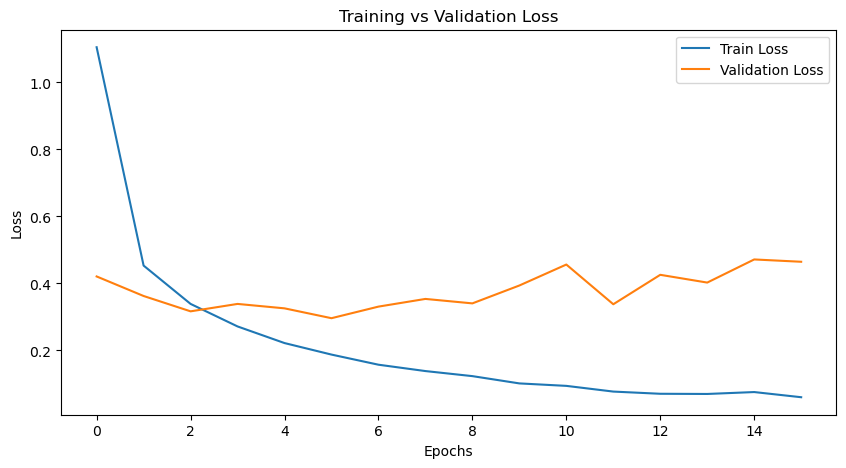

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Enable CUDA benchmarking for faster execution
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True  # Optimize GPU performance

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Use AMP (Automatic Mixed Precision) if available
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler() if use_amp else None

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Early stopping parameters
best_val_acc = 0.0
patience = 10
counter = 0

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    # Progress bar for training batches
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False)

    for images, labels, image_names in progress_bar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        if use_amp:  # Use AMP only if CUDA is available
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_acc = 100 * correct / total
    train_losses.append(total_loss / len(train_loader))

    # Validation Step
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        val_progress_bar = tqdm(test_loader, desc=f"Validating Epoch {epoch+1}", unit="batch", leave=False)
        for images, labels, image_names in val_progress_bar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with torch.cuda.amp.autocast() if use_amp else torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(test_loader))

    # Print training and validation stats
    print(f"🔥 Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}")

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        print(f"✅ Saved new best model (Epoch {epoch+1}, Val Accuracy: {best_val_acc:.2f}%)")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹ Stopping early at epoch {epoch+1}. Best Val Acc: {best_val_acc:.2f}")
            break

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

### Compute Test Accuracy of the best model and Confusion Matrix

Test Accuracy: 89.51


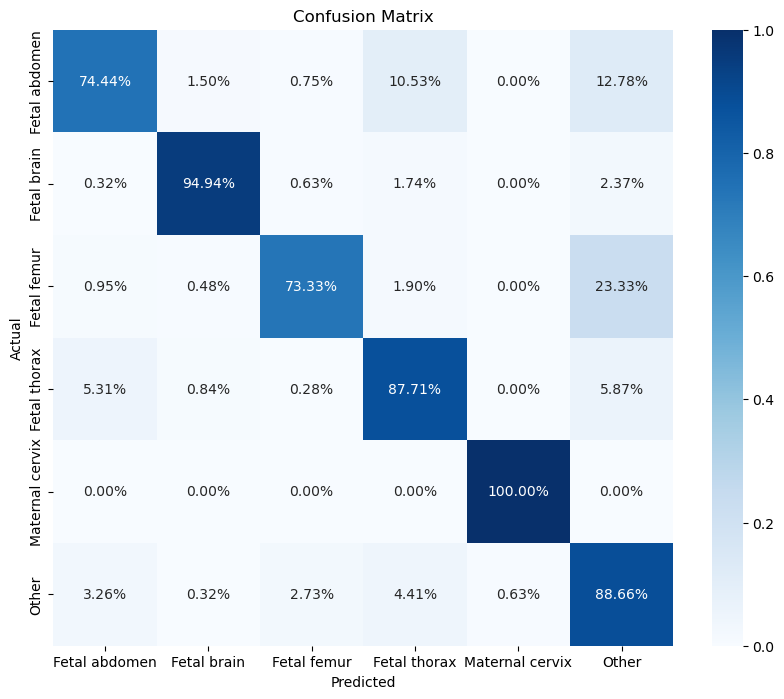

In [ ]:
#Compute test accuracy of the model and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()

correct, total = 0, 0
predictions, true_labels = [], []

with torch.no_grad():
    for images, labels, image_names in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}")

# Plot Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix to get percentages
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



### Extract Features from the best model

In [ ]:
# Extract features from the best model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tqdm import tqdm

# Load the best model
model = CustomCNN(num_classes=6).to(device)
model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()


# Remove the final classification layer
#model = nn.Sequential(*list(model.children())[:-1])

# Extract features from the model
def extract_features_with_names(dataloader, model, csv_filename):
    model.eval()
    all_features, all_labels, all_image_names = [], [], []

    with torch.no_grad():
        for images, labels, names in tqdm(dataloader, desc="Extracting Features", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Extract features using the CNN
            features = model.extract_features(images)

            # Convert to NumPy and store
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_image_names.extend(names)  # ✅ Correctly match shuffled names

    # Convert lists to NumPy arrays
    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)

    # Create Pandas DataFrame
    df = pd.DataFrame(all_features)
    df.insert(0, "Image", all_image_names)  # Insert image names in the first column
    df["Label"] = all_labels  # Append labels in the last column

    # Save as CSV file
    df.to_csv(csv_filename, index=False)
    print(f"✅ Saved features to {csv_filename}")

# ✅ Extract features correctly with dynamic name tracking
extract_features_with_names(train_loader, model, "train_features_custom_CNN.csv")
extract_features_with_names(test_loader, model, "test_features_custom_CNN.csv")



✅ Saved features to train_features_custom_CNN.csv


✅ Saved features to test_features_custom_CNN.csv


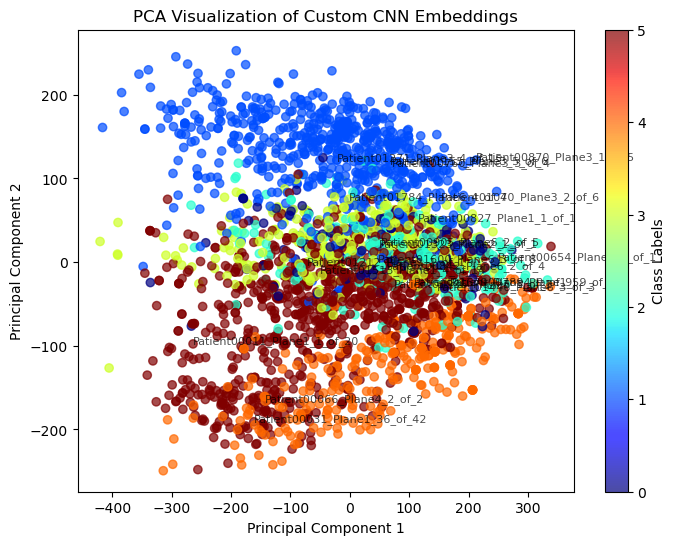

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# ✅ Load extracted features from CSV (Ensure image names and labels are included)
df = pd.read_csv("test_features_custom_CNN.csv")

# ✅ Extract features and labels correctly
image_names = df["Image"].values  # Image names
test_labels = df["Label"].values  # Labels
X_test = df.drop(columns=["Image", "Label"]).values  # Extract features only

# ✅ Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_cnn_embeddings = pca.fit_transform(X_test)

# ✅ Plot PCA visualization with class labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_cnn_embeddings[:, 0], reduced_cnn_embeddings[:, 1], c=test_labels, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("PCA Visualization of Custom CNN Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# ✅ Display image names on some points for interpretability (optional)
for i in range(0, len(image_names), len(image_names) // 20):  # Show 20 sample labels
    plt.text(reduced_cnn_embeddings[i, 0], reduced_cnn_embeddings[i, 1], image_names[i], fontsize=8, alpha=0.7)

plt.show()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


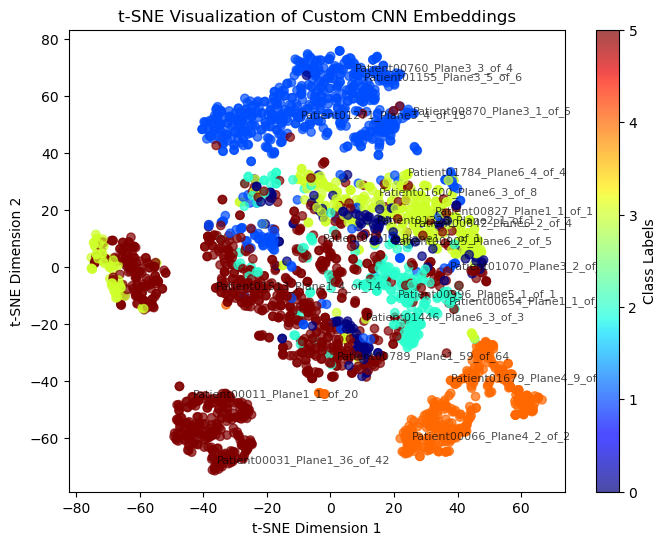

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

# ✅ Load extracted features from CSV (Ensure image names and labels are included)
df = pd.read_csv("test_features_custom_CNN.csv")

# ✅ Extract features and labels correctly
image_names = df["Image"].values  # Image names
test_labels = df["Label"].values  # Labels
X_test = df.drop(columns=["Image", "Label"]).values  # Extract features only

# ✅ Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, learning_rate=200)
reduced_cnn_tsne = tsne.fit_transform(X_test)

# ✅ Plot t-SNE visualization with class labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced_cnn_tsne[:, 0], reduced_cnn_tsne[:, 1], c=test_labels, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Class Labels")
plt.title("t-SNE Visualization of Custom CNN Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# ✅ Display image names on some points for interpretability (optional)
for i in range(0, len(image_names), len(image_names) // 20):  # Show ~20 sample labels
    plt.text(reduced_cnn_tsne[i, 0], reduced_cnn_tsne[i, 1], image_names[i], fontsize=8, alpha=0.7)

plt.show()